# Regresión lineal simple
### Modelos no paramétricos y de regresión
##### Profesor: Jorge Iván Reyes Hernández
##### Estudiante: Islas Zicatl Max Emiliano

## 1. Obtener datos
- Muestreo/experimentos.
- Web Scraping.
- etc.

## 2. EDA
- Gráfico de dispersión.

## 3. Supuestos del modelo*
Modelo: $Y = \beta_0 + \beta_1 x + \epsilon$, $\epsilon \sim \mathcal{N}(0,\sigma^2)$.
- __Linealidad__: $\mathbb{E}(Y|x) = \beta_0 + \beta_1 x \iff \mathbb{E}(\epsilon) = 0$.
- __Varianza contante__: Dado $x\in\mathbb{R}$, la varianza de $Y$ es constante $\iff$ $\mathbb{V}ar(\epsilon) = \sigma^{2}$ (independiente del $x$ dado).
- __Independencia__ (no correlación): Si $i\neq j$, $Y_i \perp Y_j \iff \epsilon_i \perp \epsilon_j$ ($\mathbb{C}ov (\epsilon_i, \epsilon_j) = 0$).
- __Normalidad__: Dado $x\in\mathbb{R}, Y$ es una v.a normal $\iff$ $\epsilon$ es una v.a normal.

## 4. Ajustar/entrenar modelo
Estimar $\beta_0, \beta_1, \sigma^{2}$ usando:
- Mínimos cuadrados.
- Máxima verosimilitud.

Bajo el supuesto distribucional ($\epsilon \sim \mathcal{N}(0,\sigma^2)$) estos estimadores coindicen ($\hat{\beta}_{i,ML} = \hat{\beta}_{i,MC}$, $i\in\{0,1\}$).

## 5. Evaluar modelo
- Coeficiente de determinación $R^{2}:\mathbb{R}^{n}\times\mathbb{R}^{n} \to [0,1]\subset\mathbb{R}$.

$R^{2}$: Proporción de la variabilidad total de $y$ que es explicada por el modelo.

$R^{2} = 1$: El $100\%$ de la variabilidad muestral en $y$ puede ser atribuida al hecho de que $x$ y $y$ están relacionadas linealmente.


## 6. Verificación de supuestos (análisis de residuales)
1. __Independencia__.
- Autocorrelograma (de los residuales muestrales $e_i$).
- Prueba de Durbin-Watson.
2. __Varianza contante__.
- Gráfico de dispersión ($e$ vs $\hat{y}$)
- Pruebas de Cook-Weisberg o de Breusch-Pagan.

3. __Normalidad__.
- qq-plot (de los residuales muestrales $e_i$).
- Pruebas de Kolmogorov-Smirnov, Anderson-Daring, etc (para los residuales muestrales $e_i$).

_Nota: Pueden usar los residuales estandarizados_
$$
    e_i ^{*} = \frac{y_i - \hat{y}_i}{s_e\sqrt{1-\frac{1}{n} - \frac{(x_i - \bar{x})^{2}}{S_{xx}} }}
$$
con $s_e = \sqrt{SSE/(n-2)}$, $i\in\{1,\ldots,n\}$, $SSE = \sum_{i=1}^{n}(y_i - \hat{y}_i)^{2}$

### Ejemplo
#### ¿El estrés realmente acelera el envejecimiento?
Un estudio descrito en el artículo "Acortamiento acelerado de telómeros en respuesta al estrés" (Proc. Nat. Acad. Sci 2004:17312-17315) investigó la relación entre $x:$ "Nivel de estrés percibido" (en escala cuantitativa) y $y:$ "Longitud de los telómeros" (una medida biológica de longevidad celular; longitudes de telómeros más pequeñas indican una vida útil más corta a nivel celular). Se tomaron muestras $(x_i, y_i)$ a 38 individuos (archivo stress_aging.csv). Realice un análisis de regresión.

In [2]:
# Descargamos las paqueterias necesarias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as pystats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.compat import lzip
from statsmodels.graphics.gofplots import qqplot
import math as m

In [3]:
# Descargamos la versión 3.4.2 de 'rpy2' para poder llamar código de R en Python 
!pip install -Iv rpy2==3.4.2


Using pip 23.0.1 from /usr/local/lib/python3.9/dist-packages/pip (python 3.9)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.1/186.1 kB 8.5 MB/s eta 0:00:00
  Running command python setup.py egg_info
  /usr/local/lib/python3.9/dist-packages/setuptools/__init__.py:85: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated. Requirements should be satisfied by a PEP 517 installer. If you are using pip, you can try `pip install --use-pep517`.
    dist.fetch_build_eggs(dist.setup_requires)
  ['cffi>=1.10.0', 'jinja2', 'pytz', 'tzlocal']
  running egg_info
  creating /tmp/pip-pip-egg-info-iixtbivj/rpy2.egg-info
  writing /tmp/pip-pip-egg-info-iixtbivj/rpy2.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-iixtbivj/rpy2.egg-info/dependency_links.txt
  writing requirements to /tmp/pip-pip-egg-info-iixtbivj/rpy2.egg-info/requires.txt
  writing top-leve

In [5]:
# También cambiamos el kernel del enviroment para que la pqueteria 'rpy2' pueda importar las librerias necesarias
!pip install -U ipykernel==5.5.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.7 MB/s eta 0:00:00


In [7]:
# Importamos las librerias necesarias para:
## Llamar código de R
import rpy2
import rpy2.robjects as robjects
## Imprimir los resultados en HTML notebooks
import rpy2.ipython.html
rpy2.ipython.html.init_printing()
## Importar librerias de R
from rpy2.robjects.packages import importr, data


In [8]:
# Importamos con un nombre especifico dichas librerias
utils = importr('utils')
base = importr('base')

In [9]:
# Importmoas las librerias que necesitaremos para aplicar el test de DurbinWatson
utils.install_packages('stats')
utils.install_packages('lmtest')
utils.install_packages('readr')
stats = importr('stats')
lmtest = importr('lmtest')
readr = importr('readr')

(as ‘lib’ is unspecified)

(as ‘lib’ is unspecified)














	‘/tmp/RtmpKsc6OW/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpKsc6OW/downloaded_packages’



In [10]:
utils.install_packages('snow')
snow = importr('snow')

(as ‘lib’ is unspecified)







	‘/tmp/RtmpKsc6OW/downloaded_packages’



##### Datos

In [11]:
data = pd.read_csv("https://raw.githubusercontent.com/MAX-ISLAS-ZICATL/estadistica2_2023-2/main/SimpleLinearRegression/stress_aging.csv")

In [12]:
data

,stress,aging
0,14,1.30
1,17,1.32
2,14,1.08
3,27,1.02
4,22,1.24
5,12,1.18
6,22,1.18
7,24,1.12
8,25,0.94
9,18,1.46


###### EDA

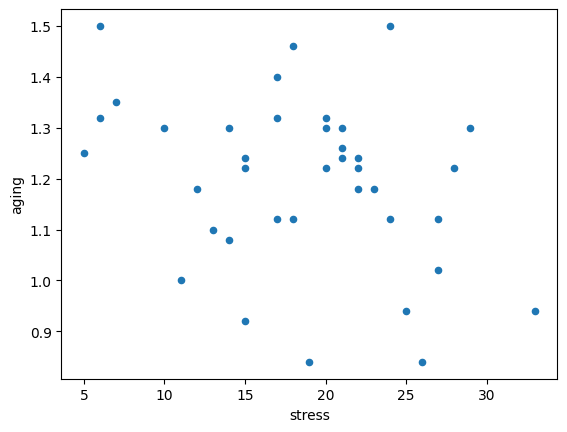

In [13]:
ax1 = data.plot.scatter(x="stress", y="aging")

##### Ajuste del modelo

In [14]:
Y = data["aging"]
X = data["stress"]

In [15]:
Y

0     1.30
1     1.32
2     1.08
3     1.02
4     1.24
5     1.18
6     1.18
7     1.12
8     0.94
9     1.46
10    1.22
11    1.30
12    0.84
13    1.18
14    1.22
15    0.92
16    1.12
17    1.40
18    1.32
19    1.35
20    1.00
21    1.24
22    1.25
23    1.26
24    1.50
25    1.24
26    1.50
27    1.30
28    1.22
29    0.84
30    1.30
31    1.12
32    1.12
33    1.22
34    1.10
35    0.94
36    1.32
37    1.30
Name: aging, dtype: float64

In [16]:
X

0     14
1     17
2     14
3     27
4     22
5     12
6     22
7     24
8     25
9     18
10    28
11    21
12    19
13    23
14    15
15    15
16    27
17    17
18     6
19     7
20    11
21    15
22     5
23    21
24    24
25    21
26     6
27    20
28    22
29    26
30    10
31    18
32    17
33    20
34    13
35    33
36    20
37    29
Name: stress, dtype: int64

In [17]:
model = sm.OLS(Y,sm.add_constant(X))

In [18]:
results = model.fit()

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  aging   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     3.963
Date:                Thu, 20 Apr 2023   Prob (F-statistic):             0.0541
Time:                        14:18:19   Log-Likelihood:                 16.955
No. Observations:                  38   AIC:                            -29.91
Df Residuals:                      36   BIC:                            -26.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3388      0.076     17.656      0.000       1.185       1.493
stress        -0.0077      0.004     -1.991      0.054      -0.015       0.000
==============================================================================
Omnibus:                        0.984   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.611   Jarque-Bera (JB):                0.688
Skew:                          -0.327   Prob(JB):                        0.709
Kurtosis:                       2.924   Cond. No.                         58.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# Parámetros estimados

results.params

const     1.338778
stress   -0.007661
dtype: float64

El modelo queda como:

$$\hat{Y}_i = 1.338778   -0.007661 X_i$$

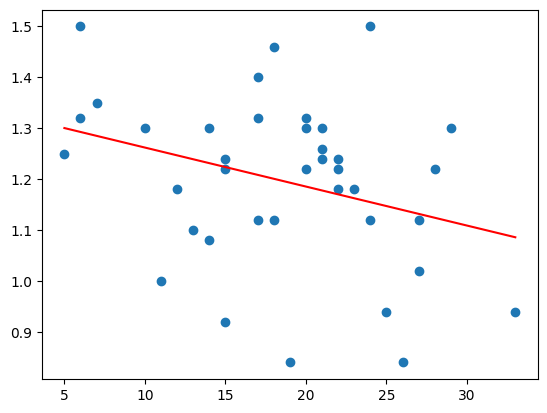

In [21]:
x = np.linspace(data["stress"].min(), data["stress"].max())
y = np.matmul(sm.add_constant(x), results.params)

plt.plot(x,y, "r")
plt.scatter(data["stress"], data["aging"])
plt.show()

##### Evaluación del modelo

In [44]:
# Coeficiente de determinación
results.rsquared_adj

0.07414383230911137

Debido a que el coeficiente de determinación indica la proporción de variación de Y explicada por el regresor X, podemos afirmar que el regresor X el estres solo explica el 7.41% de la variabilidad del envejecimiento celular.

###### Análisis de residuales


El nivel de significancia considerado es $\alpha = 0.05$

In [23]:
res = results.resid

#### Independencia
- Autocorrelograma

[statsmodels.graphics.tsaplots.plot_acf](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html)

[Interpreting ACF or Auto-correlation plot](https://medium.com/analytics-vidhya/interpreting-acf-or-auto-correlation-plot-d12e9051cd14)

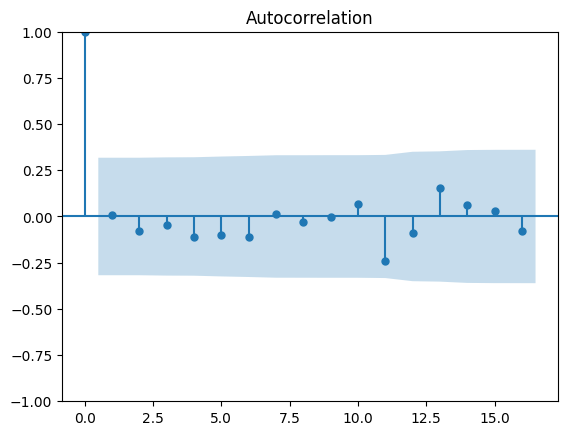

In [24]:
# Autocorrelograma

plot_acf(res)
plt.show()

Visualmente podemos decir que los residuales no estan autocorrelacionados, porque la segunda observación (y todas la demas) si se encuentran en el intervalo del 95% de confianza. Es decir, parece que los residales no estan correlacionados. 

- Prueba de Durbin-Watson

[Durbin-Watson DW test for autocorrelation](https://www.reneshbedre.com/blog/durbin-watson-test.html)

Del resumen: Durbin-Watson: 	1.944

Si la estadística es 2, no hay autocorrelación.

Si la estadística es menor que 2, hay autocorrelación positiva.

Si la estadística es mayor que 2, hay autocorrelación negativa.

__Punto extra si corren la prueba DW de R en Python__ (límite 20-04-23)

[Calling R from Python](https://rviews.rstudio.com/2022/05/25/calling-r-from-python-with-rpy2/)

In [25]:
# Volvemos a descargar la informacion y la guardamos en un objeto que R puede procesar
dataR = readr.read_csv(file = 'https://raw.githubusercontent.com/MAX-ISLAS-ZICATL/estadistica2_2023-2/main/SimpleLinearRegression/stress_aging.csv')

Rows: 38 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): stress, aging

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [26]:
# A partir de lafunción 'lm' de la librería 'stats' ajustamos un modelo de regrasión lineal
lm1 = stats.lm('aging ~ stress', data = dataR)


In [27]:
#nDe la libreria 'lmtest' empleamos la funcion 'dwtest' que usa de argumento el modelo anteriormente creado
DWT = lmtest.dwtest(lm1,alternative ="two.sided",iterations = 1000)
print(DWT)


	Durbin-Watson test

data:  structure(list(coefficients = c("(Intercept)" = 1.33877832512315, stress = -0.00766133004926109), residuals = c("1" = 0.0684802955665035, "2" = 0.111464285714286, "3" = -0.151519704433497, "4" = -0.111922413793103, "5" = 0.0697709359605911, "6" = -0.0668423645320198, "7" = 0.00977093596059106, "8" = -0.0349064039408866, "9" = -0.207245073891626, "10" = 0.259125615763547, "11" = 0.0957389162561576, "12" = 0.12210960591133, "13" = -0.353213054187192, "14" = 0.0174322660098521, "15" = -0.00385837438423653, "16" = -0.303858374384236, "17" = -0.0119224137931033, "18" = 0.191464285714286, "19" = 0.0271896551724138, "20" = 0.0648509852216749, "21" = -0.254503694581281, "22" = 0.0161416256157635, "23" = -0.0504716748768474, "24" = 0.08210960591133, "25" = 0.345093596059113, "26" = 0.06210960591133, "27" = 0.207189655172414, "28" = 0.114448275862069, "29" = 0.0497709359605911, "30" = -0.299583743842365, "31" = 0.0378349753694581, "32" = -0.0808743842364531, "33" = -

Ya que la estadística de prueba resulto en $1.9443$ y el p-value en $ 0.8432$, procedemos a **no** rechazar la hipotesis nula. Por lo cual, estadísticamente, parece ser que que los errores no estan correlacionados.

#### Varianza constante.
- Gráfico de dispersión

In [28]:
y_hat = results.params[0] + results.params[1]*X

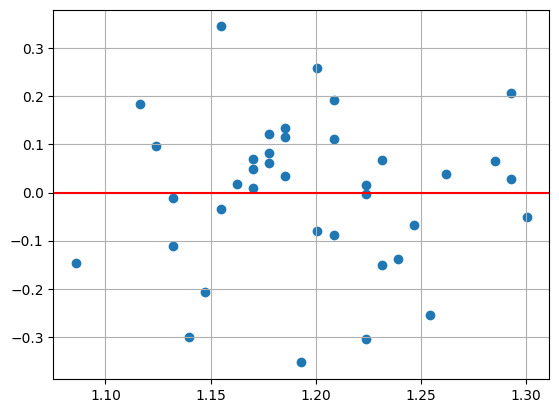

In [29]:
plt.scatter(x=y_hat, y=res )
plt.axhline(y=0, xmin=0, xmax=1.3, color = "red")
plt.grid()

En el gráfico, ligeramente una mayoría se encuentra sobre la línea del 0, no parece haber algún patrón que sigan los datos y los datos caen en un intervalo masomenos simétrico respecto al 0, por lo cual, visualmente parece ser que la varianza de los errores es constante. 

 Como los análisis gráficos suelene ser ambiguos, procedemos a realizar la prueba de Breusch-Pagan

- Prueba de Breusch-Pagan

Hip. nula: la varianza es constante

[How to Perform a Breusch-Pagan Test in Python](https://www.geeksforgeeks.org/how-to-perform-a-breusch-pagan-test-in-python/)

In [30]:
# Conduct the Breusch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
 
# Get the test result
test_result = sms.het_breuschpagan(results.resid, results.model.exog)
 
lzip(names, test_result)

[('Lagrange multiplier statistic', 0.3518811946684577),
 ('p-value', 0.5530501583398384),
 ('f-value', 0.33647691863611745),
 ('f p-value', 0.5654831049396662)]

A causa de que el p-value es 0.55305, **no** rechazamos la hipotesis nula, entonces se sostiene que la homocesteacidad.

3. __Normalidad__.
- qq-plot (de los residuales muestrales $e_i$).


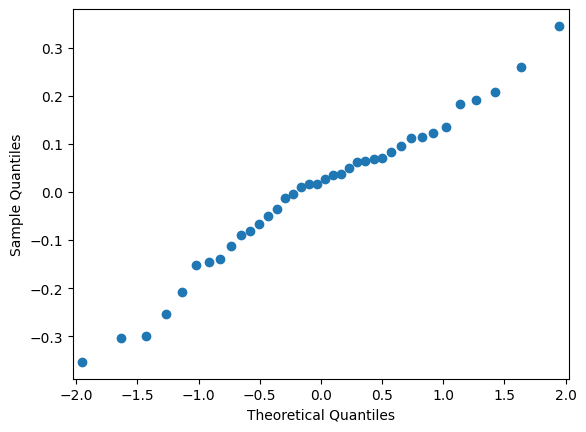

0.15695427313608998


In [35]:
Sigma =res.var()
fig = sm.qqplot(res)
plt.show()
print(m.sqrt(Sigma))

- Pruebas de Kolmogorov-Smirnov, Anderson-Daring, etc.

Hip. nula: los residuales se distribuyen normal.

In [36]:
pystats.anderson(res)

AndersonResult(statistic=0.3774309238372453, critical_values=array([0.529, 0.603, 0.723, 0.844, 1.004]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-3.2722362831057244e-16, scale=0.15695427313608998)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [37]:
pystats.shapiro(res)

ShapiroResult(statistic=0.9775760173797607, pvalue=0.6314409375190735)

Apoyandonos en la prueba de Anderson-Darling que logro ajustar una distribución normal 

Podemos decir que los residuales $$\forall i \:\: e_{i}  \thicksim N(\mu =-3.2722362831057244e-16 \approx 0, \sigma^{2} = 0.15695427313608998 )$$


Con esto se concluye, que el modelo cumple con los supestos estructurales.


**Conclusión:**

Debido a que el modelo -estadísticamente- cumple con los supuestos estrucuturales, lo que nos indique el modelo no tiene falsos soportes.


El modelo dice que la relación existente entre el estres y el envejecimiento celular es directamente proporcinal, sin embargo; como en los datos tenemos la longitud de los telomeros, el modelo describe una relación inversamente proporcional entre el estres y la longitud de los telomeros.

Sin embargo; esta relación es totalmente sútil pues el modelo recordemos que el modelo resultante es:

$$\hat{Y}_i = 1.338778   -0.007661 X_i$$

Es decir; la pendiente es muy cercana a 0. Esto al parecer tuvo efecto en el coeficiente de determinación pues la estadística $R^{2}$ fue igual al 7.41%.
Por lo cual, solo el 7.41 % de la variación de la longitud de los telomeros fue explicada por el estres. 

Por ende, aunque pequeña, si existe una relación entre el regresor del estres y la longitud de los telomeros. Sin embargo; **el modelo no se recomienda para fines predictivos**. Para la utilidad del modelo en este ambito sería necesario revisar la muestra o modificar la variable de respuesta.

**Sugerencias:**


Con la muestra, debido a el amplio rango de variación en la longitud telomérica de la población general se dificulta su interpretación. Por lo cual es recomendable, estudiar a la población en grupos especificos, tanto en ocupación y edad.

Algunos investigadores sugieren que quizás el porcentaje de telómeros cortos podría ser un marcador más sensible de envejecimiento celular que la longitud media telomérica en situaciones de estrés agudo, por lo cual, podría modificarse la variable de respuesta.

Otra opción es hacer un modelo de regresión multiple donde se consideren regresores relativos a enfermedades como cáncer, depresión o Sindrome de Cushing o generar algún indicador de resistencia genética al estrés.

Ideas para conocer que otra variables pueden influir en el acortamiento de los telomeros se consulto:

Aulinas, A., Santos, A., Valassi, E., Mato, E., Crespo, I., Giustina, A., Roig, O., Bell, O., & Webb, S. M. (2013). Telómeros, envejecimiento y síndrome de Cushing: ¿están relacionados? Endocrinología y Nutrición. https://doi.org/10.1016/j.endonu.2012.10.002